# Приоритизация гипотез и анализ A/B-теста. #

Совместно с отделом маркетинга подготовлен список гипотез для увеличения выручки.

**Цель** - принятие решения по результатам теста.

**Задачи:**
- приоритизация гипотез, 
- запуск A/B-теста,
- анализ результатов A/B-теста.

**Исходные данные.**

1. Файл /datasets/hypothesis.csv

Hypothesis — краткое описание гипотезы;

Reach — охват пользователей по 10-балльной шкале;

Impact — влияние на пользователей по 10-балльной шкале;

Confidence — уверенность в гипотезе по 10-балльной шкале;

Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

2. Файл /datasets/orders.csv

transactionId — идентификатор заказа;

visitorId — идентификатор пользователя, совершившего заказ;

date — дата, когда был совершён заказ;

revenue — выручка заказа;

group — группа A/B-теста, в которую попал заказ.

3. Файл /datasets/visitors.csv

date — дата;

group — группа A/B-теста;

visitors — количество пользователей в указанную дату в указанной группе A/B-теста

**Данное исследование разделим на несколько частей.**

***Часть 1. Изучение общей информации:***
* [1. Обзор файлов с данными, получение общей информации, загрузка библиотек.](#1-bullet)
* [2. Подготовка данных: приведение данных к хорошему стилю, проверка на дубликаты.](#2-bullet)
* [3. Проверка на дублирование пользователей в разных группах, исключение ошибочных пользователей.](#3-bullet)

***Часть 2. Приоритизация гипотез:***
* [4. Фреймворк ICE.](#4-bullet)
* [5. Фреймворк RICE.](#5-bullet)

***Часть 3. A/B-тест:***
* [6. График кумулятивной выручки по группам.](#6-bullet)
* [7. График кумулятивного среднего чека по группам](#7-bullet)
* [8. График относительного изменения кумулятивного среднего чека группы B к группе A.](#8-bullet)
* [9. График кумулятивного среднего количества заказов на посетителя по группам.](#9-bullet)
* [10. График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.](#10-bullet)
* [11. Точечный график количества заказов по пользователям..](#11-bullet)
* [12. 95-й и 99-й перцентили количества заказов.](#12-bullet)
* [13. Точечный график стоимостей заказов.](#13-bullet)
* [14. 95-й и 99-й перцентили стоимости заказов.](#14-bullet)
* [15. Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.](#15-bullet)
* [16. Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным.](#16-bullet)
* [17. Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.](#17-bullet)
* [18. Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным..](#18-bullet)

[***Часть 4. Выводы и рекомендации.***](#19-bullet)

<a id='1-bullet'></a>
## Изучение общей информации. ##

In [1]:
# сразу загрузим необходимые библиотеки
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()

In [2]:
# откроем датасеты
hypothesis = pd.read_csv('C:\ПРОЕКТЫ/hypothesis.csv', sep=',')
orders = pd.read_csv('C:\ПРОЕКТЫ/orders.csv', sep=',')
visitors = pd.read_csv('C:\ПРОЕКТЫ/visitors.csv', sep=',')

In [3]:
# посмотрим на содержимое
display(hypothesis)
display(orders.head())
visitors.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [4]:
# изучим информацию о датасете
hypothesis.info()
orders.info()
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   

Пропусков в данных нет. Столбцы с датой имеют тип object. Названия колонок необходимо привести к хорошему стилю.

In [5]:
# первым делом исправим названия колонок
orders = orders.rename(columns={'transactionId':'transaction_Id','visitorId':'visitor_Id'})

<a id='2-bullet'></a>

In [6]:
# приведем названия колонок к нижнему регистру
hypothesis.columns = hypothesis.columns.str.lower()
orders.columns = orders.columns.str.lower()

In [7]:
# проверим на наличие явных дубликатов
display(orders['transaction_id'].duplicated().sum())
display(orders.duplicated().sum())
visitors.duplicated().sum()

0

0

0

In [8]:
# и на наличие не явных
visitors.duplicated(subset=['date','group']).sum()

0

In [9]:
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [10]:
# проверим, есть ли дубли в группах
double_visitors = orders.groupby('visitor_id').agg({'group':'nunique'}).query('group>1').count()
double_visitors

group    58
dtype: int64

<a id='3-bullet'></a>

58 пользователей состоят в обеих группах одновременно. 

In [11]:
# удалим их из обеих групп
double_visitors = orders.groupby('visitor_id').agg({'group':'nunique'}).reset_index().query('group>1')['visitor_id'].unique()
orders = orders.query('visitor_id not in @double_visitors')

Названия колонок приведены к хорошему стилю, сделана проверка на явные и не явные дубликаты, пользователи ошибочно попавшие в обе группы исключены. Данные готовы для дальнейшей работы.

## Приоритизация гипотез. ##
Для приоритизации гипотез воспользуемся методами ICE и RICE. 
Reach — скольких пользователей затронет изменение.
Impact — насколько сильно изменение повлияет на опыт пользователей.
Confidence — уверенность, что это изменение повлияет на пользователей именно так. 
Efforts — сколько стоит протестировать эту гипотезу.  
Чтобы вычислить ICE, перемножим Impact и Confidence и разделим на третий. 
Чтобы вычислить RICE, перемножим первые три параметра и разделим на четвертый. 
Результаты ранжируем. 

<a id='4-bullet'></a>

In [12]:
# посчитаем ICE для гипотез
hypothesis['ICE'] = (hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']
pd.options.display.max_colwidth = 400
display(hypothesis[['hypothesis','ICE']].sort_values(by='ICE', ascending=False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


<a id='5-bullet'></a>

In [13]:
# применим фреймворк RICE для гипотез
hypothesis['RICE'] = (hypothesis['reach']*hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']
display(hypothesis[['hypothesis','RICE']].sort_values(by='RICE', ascending=False))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Наиболее перспективные гипотезы по ICE под номерами 8, 0, 7. 
По методу RICE снова перспективна гипотеза под номером 7, но она уже на первом месте и с большим преимуществом. Гипотеза под номером 0 на третьем, а гипотеза 8 в лидерах уже не значится. Зато выходят на первые позиции гипотезы 2 и 6. 
Так произошло, потому что добавился весьма важный параметр - reach - охват, который затронет гипотеза.

Далее займемся анализом проведенного А/В теста.


## A/B-тест. ##

<a id='6-bullet'></a>

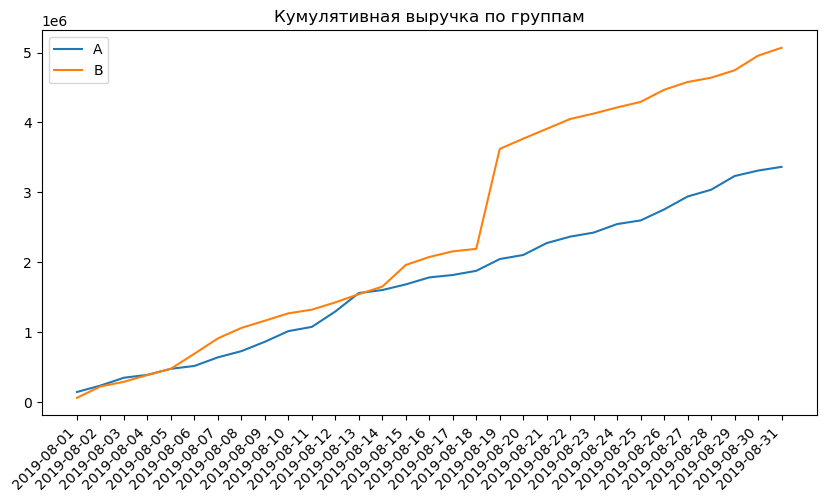

In [14]:
# построим график кумулятивной выручки по группам 
datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе A
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(10, 5))
plt.title('Кумулятивная выручка по группам')
plt.xticks(rotation=45, ha='right')
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend()
plt.show()

Сегмент В в середине теста резко подскочил и лидировал весь остаток теста.

<a id='7-bullet'></a>

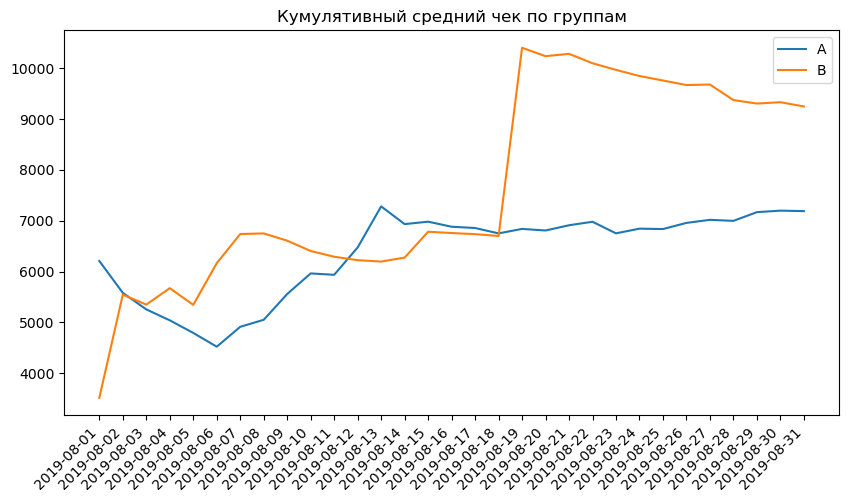

In [15]:
# построим график кумулятивного среднего чека по группам 
plt.figure(figsize=(10, 5))
plt.title('Кумулятивный средний чек по группам')
plt.xticks(rotation=45, ha='right')
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend() 
plt.show()

Кумулятивное значение чека колебалось до середины теста, далее у группы А ровное слегка восходящее движение, у группы В  резкий подъем и далее тенденция к плавному небольшому снижению.

<a id='8-bullet'></a>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


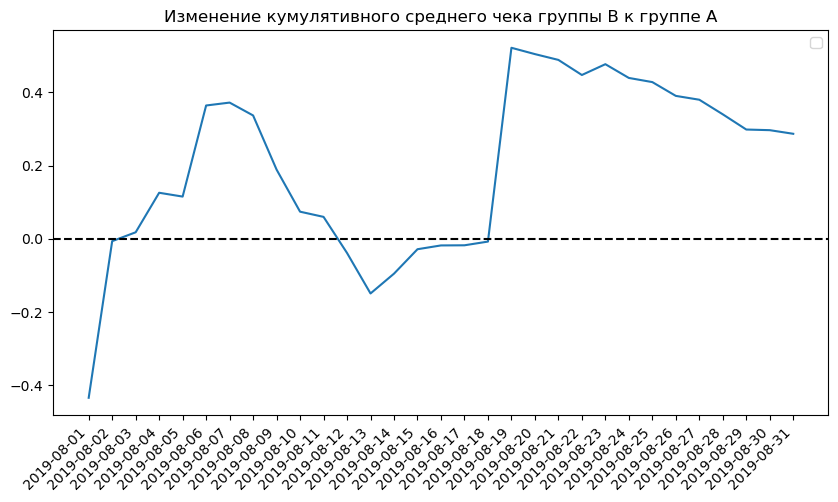

In [16]:
# построим график относительного изменения кумулятивного среднего чека группы B к группе A
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.figure(figsize=(10, 5))
plt.title('Изменение кумулятивного среднего чека группы B к группе A')
plt.xticks(rotation=45, ha='right')
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])\
         /(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.legend()
plt.show()

Результаты теста значительно и резко менялись в несколько дат. Возможно, в эти даты были совершены аномальные заказы.
Отметим резкий подъем в середине теста. В это же время также значительно выросла кумулятивная выручка и средний чек группы В.

<a id='9-bullet'></a>

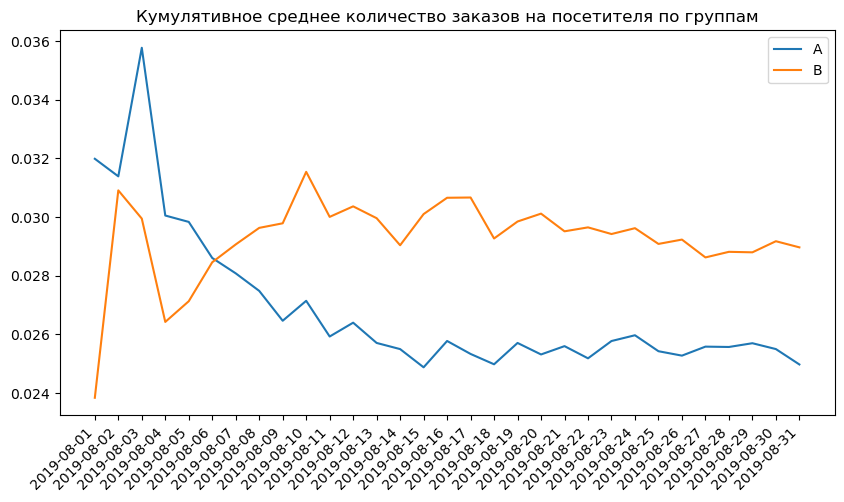

In [17]:
# построим график кумулятивного среднего количества заказов на посетителя по группам.
cumulativeData['average_order'] = cumulativeData['orders']/cumulativeData['visitors']

cumulativeAverageOrderA = cumulativeData[cumulativeData['group']=='A'][['date','visitors', 'average_order']]
cumulativeAverageOrderB = cumulativeData[cumulativeData['group']=='B'][['date','visitors', 'average_order']]


plt.figure(figsize=(10, 5))
plt.title('Кумулятивное среднее количество заказов на посетителя по группам')
plt.xticks(rotation=45, ha='right')
plt.plot(cumulativeAverageOrderA['date'], cumulativeAverageOrderA['average_order'], label='A')
plt.plot(cumulativeAverageOrderB['date'], cumulativeAverageOrderB['average_order'], label='B')
plt.legend() 
plt.show()



В начале сегмент А имел большее значение, но в течение теста довольно резко снизился и зафисксировался примерно на одном уровне, гораздо ниже сегмента В. 

Сегмент В начально резко скакнул, снизился и начал уверенное восхождение. После пересечения с сегментом А установился стабильный уровень выше сегмента А на 4 пункта. 

<a id='10-bullet'></a>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


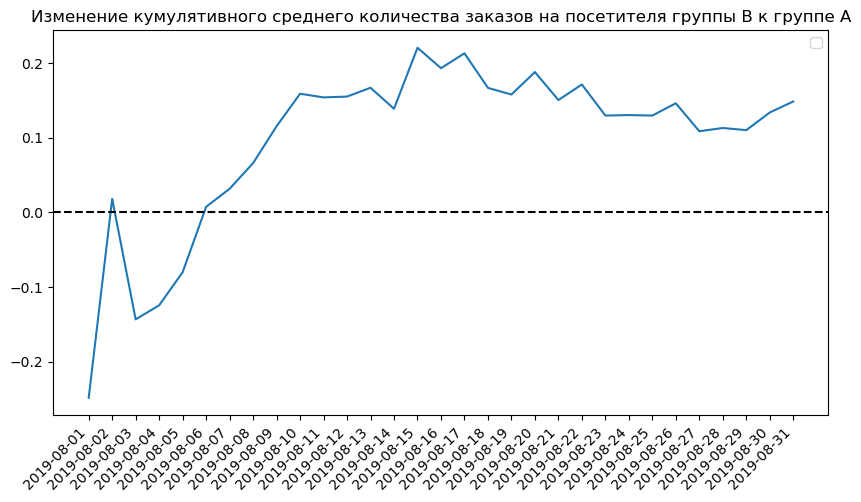

In [18]:
 # построим  график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A
mergedCumulativeAverageOrder = cumulativeAverageOrderA.merge(cumulativeAverageOrderB, left_on='date', right_on='date', \
                                                             how='left', suffixes=['A', 'B'])

# cтроим отношение среднего количества заказов
plt.figure(figsize=(10, 5))
plt.title('Изменение кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xticks(rotation=45, ha='right')
plt.plot(mergedCumulativeAverageOrder['date'], (mergedCumulativeAverageOrder['average_orderB']/\
                                                mergedCumulativeAverageOrder['visitorsB'])\
         /(mergedCumulativeAverageOrder['average_orderA']/mergedCumulativeAverageOrder['visitorsA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.legend()
plt.show()   

Группа В уверенно лидирует по заказам с резким пиком и провалом в начале. Прирост количества заказов стал более ровным в середине теста и зафиксировался на уровне 10-15% прироста к групе А.

<a id='11-bullet'></a>

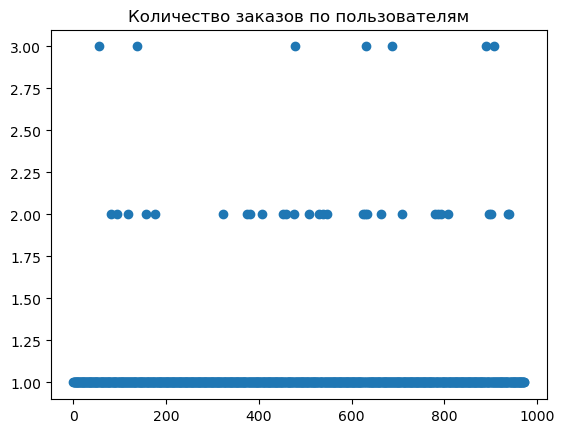

In [19]:
# построим график количества заказов по пользователям
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
ordersByUsers.columns = ['visitor_id', 'orders']

# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))


plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Количество заказов по пользователям')
plt.show()

Четко видно, что подавляющее большинство пользователей делат по 1 заказу, меньшая часть 2 и совсем маленькая 3.

<a id='12-bullet'></a>

In [20]:
# посчитаем 95-й и 99-й перцентили количества заказов на пользователя.
display(ordersByUsers.sort_values(by='orders', ascending=False).head(10))
np.percentile(ordersByUsers['orders'], [95, 99]) 

,visitor_id,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


array([1., 2.])

Не более 5% пользователей оформляли больше 1 (т. е. 2) заказа. И 1% пользователей заказывали более 2 раз. 

<a id='13-bullet'></a>

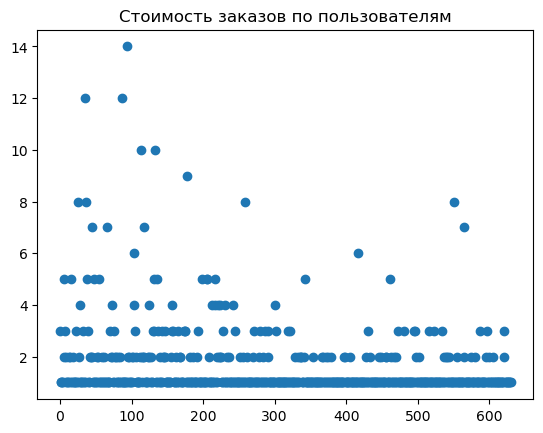

In [21]:
# построим точечный график стоимостей заказов
revenueByUsers = (
    orders.groupby('revenue', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
revenueByUsers.columns = ['revenue', 'orders']

# серия из чисел от 0 до количества наблюдений в revenueByUsers
x_values = pd.Series(range(0, len(revenueByUsers)))


plt.scatter(x_values, revenueByUsers['orders']) 
plt.title('Стоимость заказов по пользователям')
plt.show()

Наибольшая часть заказов имеет стоимость в пределах 20-25 тысяч. Выясним подробнее.

<a id='14-bullet'></a>

In [22]:
# посчитаем 95-й и 99-й перцентили стоимости заказов.
np.percentile(orders['revenue'], [95, 99])

array([26785., 53904.])

Только 5% заказов превышают стоимость 26785р. и 1% больше 53904р. 

Определим нормальную границу стоимости заказа 22000р.

Сформулируем гипотезы.

Нулевая: различий в среднем количестве заказов между группами нет. 

Альтернативная: различия в среднем между группами есть.

<a id='15-bullet'></a>

In [23]:
# посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)


ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders'] 

pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')
 
[ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')]

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

display("p-value {0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

display("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))
 

'p-value 0.01102'

'0.160'

Р-value = 0.01102, меньше 0.05.  Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем.
Относительный выигрыш группы B - 16%.

Проверим статистическую значимость различий в среднем чеке между сегментами.
Сформулируем гипотезы.

Нулевая: различий в среднем чеке между группами нет. 

Альтернативная: различия в среднем чеке между группами есть.

Также найдём относительные различия в среднем чеке между группами.

<a id='16-bullet'></a>

In [24]:
# посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным
display('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
display('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

'0.829'

'0.287'

P-value значительно больше 0.05. Значит, нулевую гипотезу, что различий в среднем чеке между группами нет, не отвергаем. Наблюдаемое различие среднего чека групп в 28% не является статистически значимым.

Очистим данные от аномалий и взглянем на результаты.

<a id='17-bullet'></a>

In [25]:
# определим список аномальных пользователей
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']

usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitor_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 22000]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
display(abnormalUsers.head(5))


568     113298937
1099    148427295
461     154576532
928     204675465
33      249864742
Name: visitor_id, dtype: int64

In [26]:
# очистим данные от аномальных значений 
# и посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 
display('{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
display('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

'0.01400'

'0.180'

Р-value = 0.01400, меньше 0.05.  
Относительный выигрыш группы B - 18%.
Очищенные данные показывают такой же результат, как сырые. Статистическая значимость достигнута. Сегмент В выигрывает у сегмента А.

Проверим статистическую значимость чистых данных по среднему чеку.

<a id='18-bullet'></a>

In [27]:
# посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным
display(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

display(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

'0.605'

'-0.062'

По чистым данным средний чек группы B ниже среднего чека группы A на 6% - аномалии влияли на данные. Но статистически значимым данное различие не является. Т.к. p-value значительно больше 0.05. Значит, нулевую гипотезу, что различий в среднем чеке между группами нет, не отвергаем.

<a id='19-bullet'></a>

## Выводы и рекомендации. ##
Подытожим:
- Достигнуто статистически значимое различие по среднему количеству заказов между группами по «сырым» и по данным после фильтрации аномалий;
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
- График различия среднего количества заказов между группами сообщает, что результаты группы B лучше группы A;
- График кумулятивного среднего чека и кумулятивной выручки по группам говорят о том, что результаты группы B лучше группы А. 
- График относительного изменения кумулятивного среднего чека группы B к группе A демонстрирует тоже самое, но есть небольшая плавная тенденция к уменьшению разницы чеков к концу теста.

Исходя из обнаруженных фактов, тест следует остановить, признать его успешным и зафиксировать победу группы В.

